# Correlation CPM vs. ME-model Fluxes

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

In [2]:
# model = coralme.io.json.load_json_me_model("../ACCELERATE/models/pputida-2024_05_20/KT2440-UPF36-DLKcat-Transport10.json")

### Load predictions

In [3]:
fluxes = pandas.read_csv("./datasets/predictions/KT2440-UPF36-M9.csv",index_col=0)

In [4]:
pred = fluxes[fluxes.index.str.contains("translation_")]["fluxes"]*1e9
pred.name = "predicted"
pred.index = [r.split("translation_")[-1] for r in pred.index]

### Load omics data

In [5]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [6]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [7]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [8]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

### Combine results

In [9]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te").join(pred)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem
PP_0001,115.346129,101.379836,117.392753,0.428368,1.142857,1.386889,269.268957,88.707377,84.644676,NaN,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0010,649.987487,654.840617,574.275588,0.870122,2.032432,1.871958,747.007359,322.195592,306.777985,NaN,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN
PP_0097,20.691063,14.890996,21.743415,0.053546,0.358301,0.321102,386.416850,41.560009,67.714909,NaN,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN
PP_0947,32.817598,33.777137,39.853891,0.087012,0.129730,0.136639,377.160906,260.365490,291.672262,NaN,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN
PP_0948,14.117067,14.164606,29.334633,0.046853,0.098842,0.109311,301.307316,143.306005,268.358322,NaN,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN


In [10]:
ResultsAnnotated.to_csv("./datasets/performance/KT2440-UPF36-M9-ResultsAnnotated.csv")

###  Group by subsystem

In [11]:
ResultsGrouped = ResultsAnnotated[rna_samples+samples+["predicted","subsystem"]].groupby("subsystem").sum()
ResultsGrouped[te_samples] = ResultsGrouped[samples].div(ResultsGrouped[rna_samples].rename(columns={i:j for i,j in zip(rna_samples,samples)}),axis=1)

In [12]:
ResultsGrouped["predicted"] = ResultsGrouped["predicted"] + 1

In [13]:
ResultsGrouped["predicted"].sort_values()

subsystem
Metabolic:Aliphatic open-chain ketones metabolism                                     1.000000e+00
Metabolic:Biomass and maintenance functions                                           1.000000e+00
Metabolic:Murein Recycling                                                            1.000000e+00
Metabolic:S_Alternate_Carbon_and_Nitrogen_source__Amines_and_Polyamines_Metabolism    1.000000e+00
Metabolic:S_Alternate_Carbon_and_Nitrogen_source__Dipeptide_Metabolism                1.000000e+00
                                                                                          ...     
Post-translation                                                                      2.346718e+05
Metabolic:S_TCA_Cycle                                                                 3.794878e+05
Transcription                                                                         7.532937e+05
Translation                                                                           1.258045e+06


### Ribo

In [18]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

In [19]:
import cobra
cobra.__version__

'0.29.1'

PearsonRResult(statistic=0.7488331855653372, pvalue=2.0899517636837922e-51)


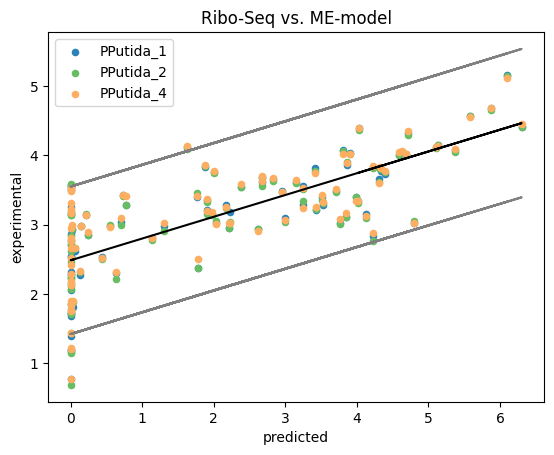

In [20]:
slist = samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("Ribo-Seq vs. ME-model")

plt.savefig("./figures/riboseq-cpm-bysubsystem-performance.svg",format="svg")

In [21]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/ribo-memodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,2.625305,1.439027,3.568939,2.503983,0.05486
Metabolic: No subsystem,PPutida_2,2.668637,1.439027,3.568939,2.503983,0.05486
Metabolic: No subsystem,PPutida_4,2.661913,1.439027,3.568939,2.503983,0.05486
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,0.766461,1.421668,3.551818,2.486743,0.00000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,0.687245,1.421668,3.551818,2.486743,0.00000


### RNA

PearsonRResult(statistic=0.6894501012403282, pvalue=1.1041681672706674e-40)


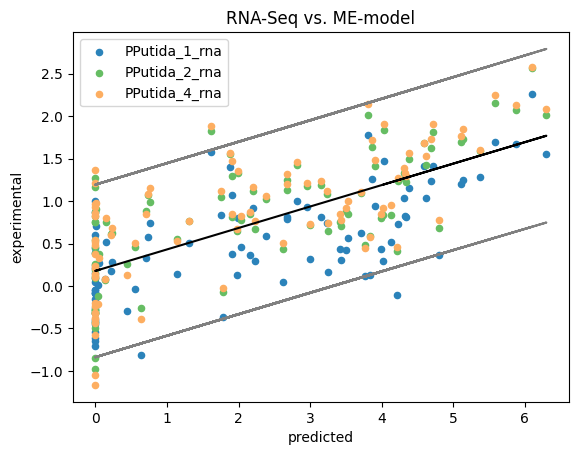

In [22]:
slist = rna_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("RNA-Seq vs. ME-model")

plt.savefig("./figures/rnaseq-cpm-bysubsystem-performance.svg",format="svg")

In [23]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/rna-memodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,0.264969,-0.824435,1.208245,0.191905,0.05486
Metabolic: No subsystem,PPutida_2,0.381885,-0.824435,1.208245,0.191905,0.05486
Metabolic: No subsystem,PPutida_4,0.334233,-0.824435,1.208245,0.191905,0.05486
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,-0.540895,-0.838410,1.194498,0.178044,0.00000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,-0.978731,-0.838410,1.194498,0.178044,0.00000


## TE

PearsonRResult(statistic=0.3783212451441323, pvalue=6.346158098028939e-11)


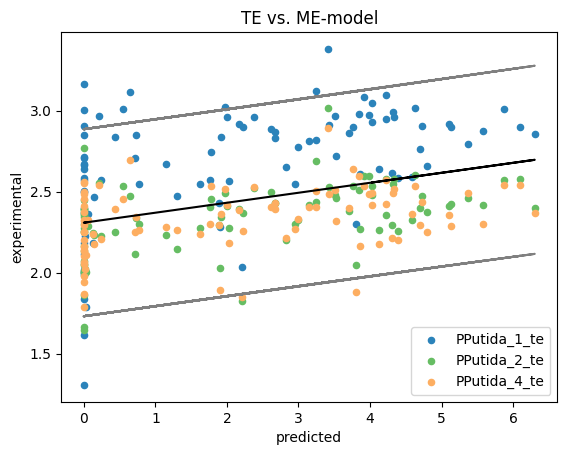

In [24]:
slist = te_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("TE vs. ME-model")

plt.savefig("./figures/te-cpm-bysubsystem-performance.svg",format="svg")

In [25]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.to_csv("./datasets/performance/te-memodel.csv")
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,2.360336,1.734951,2.889206,2.312078,0.05486
Metabolic: No subsystem,PPutida_2,2.286753,1.734951,2.889206,2.312078,0.05486
Metabolic: No subsystem,PPutida_4,2.327680,1.734951,2.889206,2.312078,0.05486
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,1.307355,1.731507,2.885891,2.308699,0.00000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,1.665976,1.731507,2.885891,2.308699,0.00000


# By sample

### Ribo

PearsonRResult(statistic=0.7505420427807147, pvalue=4.6777038529719155e-18)
PearsonRResult(statistic=0.7489168906305703, pvalue=6.0381265556707534e-18)
PearsonRResult(statistic=0.7473255301679366, pvalue=7.738367427175147e-18)


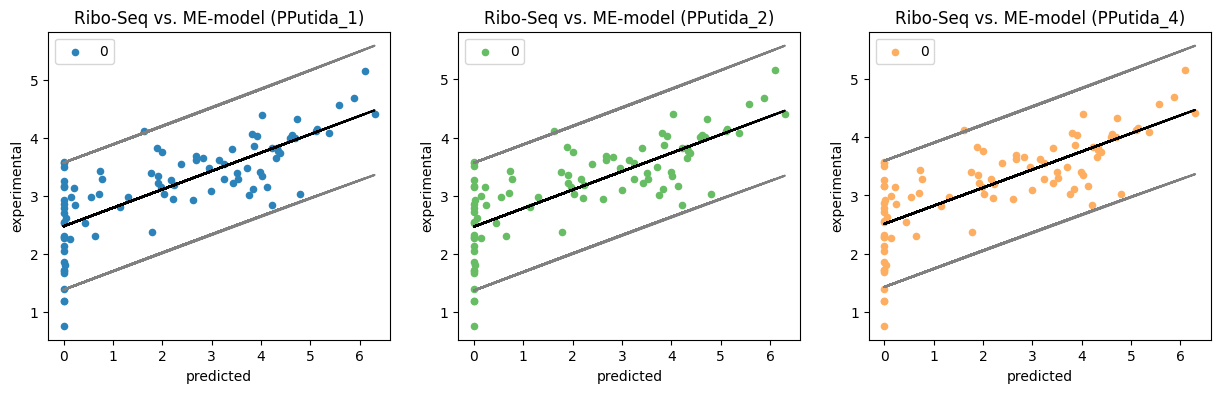

In [26]:
slist = samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(slist):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### TE

PearsonRResult(statistic=0.49814108085358105, pvalue=3.7568064983771517e-07)
PearsonRResult(statistic=0.4808819201748879, pvalue=1.0668910959574527e-06)
PearsonRResult(statistic=0.3492575073412373, pvalue=0.000600720883301463)


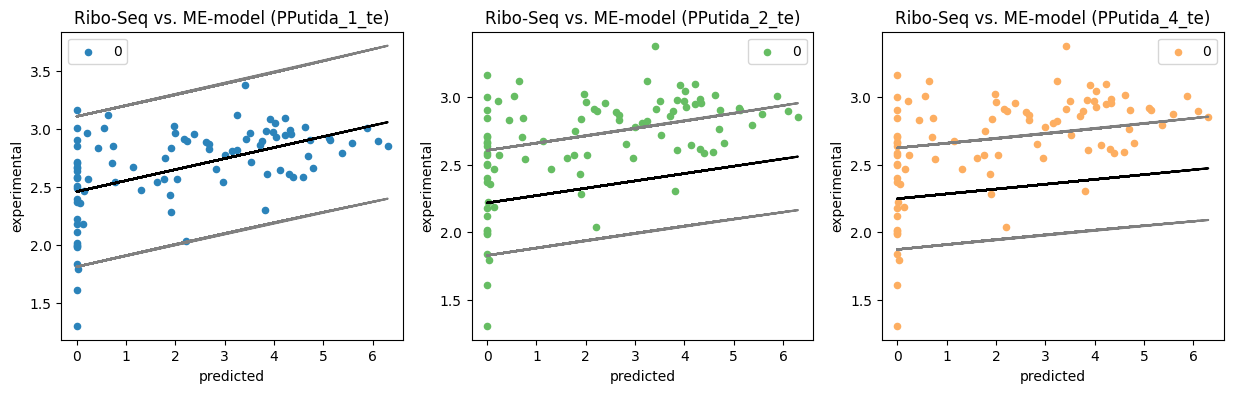

In [27]:
slist = te_samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(slist):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### Subsystems

In [28]:
def calculate_score(df,cutoff=100):
    experimental = df[df>cutoff].any(axis=1)
    experimental.name = "experimental"
    predicted = df["predicted"]>1e-16
    results = pandas.concat([experimental,predicted],axis=1)

    TP = results[(results["experimental"] == True) & (results["predicted"] == True)].shape[0]
    TN = results[(results["experimental"] == False) & (results["predicted"] == False)].shape[0]
    FP = results[(results["experimental"] == False) & (results["predicted"] == True)].shape[0]
    FN = results[(results["experimental"] == True) & (results["predicted"] == False)].shape[0]

    T = TP + FN
    N = TN + FP
    
    dct =  {"TP":TP,"TN":TN,"FP":FP,"FN":FN}
    dct["TPR"] = TP/T if T else numpy.nan
    dct["TNR"] = TN/N if N else numpy.nan
    dct["FDR"] = FP/(TP+FP)
    dct["FOR"] = FN/(TN+FN)
    dct["BA"] = (dct["TPR"] + dct["TNR"])/2
    dct["MCC"] = numpy.sqrt(dct["TPR"]*dct["TNR"]*(1-dct["FDR"])*(1-dct["FOR"]))
    return dct,results

<Axes: >

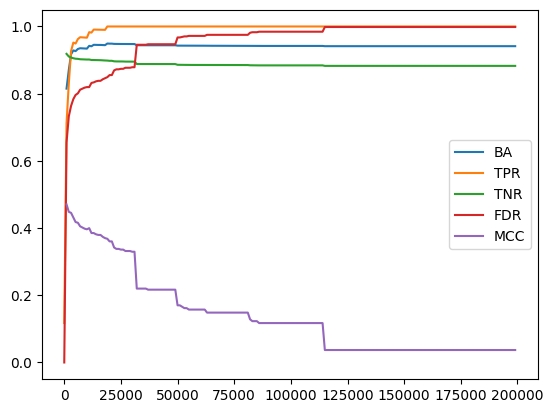

In [29]:
Res = {}
for i in range(0,200000,1000):
    dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

<Axes: >

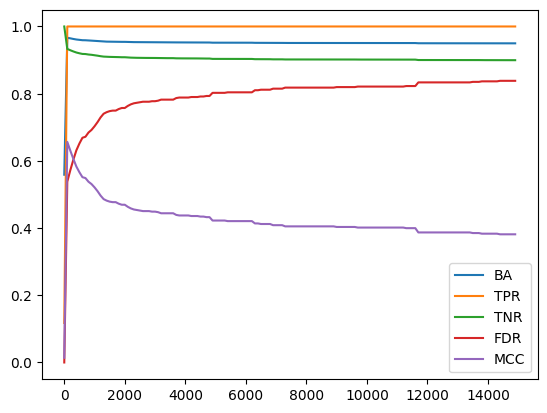

In [30]:
Res = {}
for i in range(0,15000,100):
    dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

In [31]:
pandas.DataFrame.from_dict(Res)

,0,100,200,300,400,500,600,700,800,900,...,14000,14100,14200,14300,14400,14500,14600,14700,14800,14900
TP,643.000000,297.000000,275.000000,255.000000,237.000000,224.000000,213.000000,211.000000,203.000000,198.000000,...,105.000000,105.000000,105.000000,105.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
TN,8.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,...,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000,4833.000000
FP,0.000000,346.000000,368.000000,388.000000,406.000000,419.000000,430.000000,432.000000,440.000000,445.000000,...,538.000000,538.000000,538.000000,538.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
FN,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TPR,0.117593,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TNR,1.000000,0.933192,0.929244,0.925685,0.922504,0.920221,0.918298,0.917949,0.916556,0.915688,...,0.899832,0.899832,0.899832,0.899832,0.899665,0.899665,0.899665,0.899665,0.899665,0.899665
FDR,0.000000,0.538103,0.572317,0.603421,0.631415,0.651633,0.668740,0.671851,0.684292,0.692068,...,0.836703,0.836703,0.836703,0.836703,0.838258,0.838258,0.838258,0.838258,0.838258,0.838258
FOR,0.998345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BA,0.558797,0.966596,0.964622,0.962842,0.961252,0.960110,0.959149,0.958974,0.958278,0.957844,...,0.949916,0.949916,0.949916,0.949916,0.949832,0.949832,0.949832,0.949832,0.949832,0.949832
MCC,0.013952,0.656535,0.630414,0.605893,0.583113,0.566193,0.551539,0.548839,0.537925,0.531008,...,0.383328,0.383328,0.383328,0.383328,0.381462,0.381462,0.381462,0.381462,0.381462,0.381462


In [28]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=1000)
dct

{'TP': 222,
 'TN': 4744,
 'FP': 420,
 'FN': 90,
 'TPR': 0.7115384615384616,
 'TNR': 0.9186676994577847,
 'FDR': 0.6542056074766355,
 'FOR': 0.018618121638394703,
 'BA': 0.8151030804981232,
 'MCC': 0.4709842712886844}

In [29]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=12000)
dct

{'TP': 107,
 'TN': 4834,
 'FP': 535,
 'FN': 0,
 'TPR': 1.0,
 'TNR': 0.9003538834047309,
 'FDR': 0.8333333333333334,
 'FOR': 0.0,
 'BA': 0.9501769417023654,
 'MCC': 0.3873744707223943}